In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [3]:
mean_gray = 0.1307
stddev_gray = 0.3081

In [4]:
#input [channel] = input[channel] - mean[channel] / std[channel]

transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean_gray,stddev_gray)
                               ])
train_dataset = datasets.MNIST(root = './data',
                               train = True,
                               transform = transform,
                               download = True)
test_dataset = datasets.MNIST(root = './data',
                               train = False,
                               transform = transform)

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


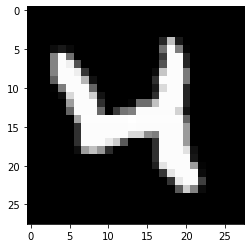

In [5]:
random_img = train_dataset[20][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_img.reshape(28,28), cmap = 'gray')

In [6]:
print(train_dataset[20][1])

4


In [7]:
batch_size = 100
train_load = torch.utils.data.DataLoader(dataset = train_dataset,
                                        batch_size = batch_size,
                                        shuffle = True)
test_load = torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size = batch_size,
                                        shuffle = False)

In [8]:
len(train_load)

600

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Conv2d(in_channels= 1, out_channels= 8, kernel_size= 3, stride= 1, padding= 1)
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size= 2)
        self.cnn2 = nn.Conv2d(in_channels= 8, out_channels= 32, kernel_size= 5, stride= 1, padding= 2)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32*7*7, 600)
        self.dropout = nn.Dropout(p= 0.5)
        self.fc2 = nn.Linear(600,10)
    
    def forward(self, x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = out.view(-1, 32*7*7) #zmiana rozmiaru - spłaszczenie (flatten)
        
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [10]:
CUDA = torch.cuda.is_available()

In [11]:
model = CNN()
if CUDA:
    model = model.cuda()

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.01)

In [13]:
#training and testing
epochs = 1
train_loss = []
train_accuracy = []

test_loss = []
test_accuracy = []

for epoch in range(epochs):
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train()
    for i,(inputs, labels) in enumerate(train_load):
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        output = model(inputs)
        loss = loss_fn(output,labels)
        iter_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(output, dim= 1)
        correct += (predicted == labels).sum().item()
        iterations += 1
    
    train_loss.append(iter_loss/iterations)
    train_accuracy.append(correct/len(train_dataset))
    
    
    correct = 0
    iterations = 0
    iter_loss = 0.0
    test_errors = []
    model.eval()
    
    for i,(inputs, labels) in enumerate(test_load):
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        output = model(inputs)
        loss = loss_fn(output,labels)
        iter_loss += loss.item()
        
        _, predicted = torch.max(output, dim= 1)
        for j in range(len(predicted)):
            if predicted[j] == labels[j]:
                correct += 1
            else:
                test_errors.append( 100*i + j)
                
        #correct += (predicted == labels).sum().item()
        iterations += 1
    
    test_loss.append(iter_loss/iterations)
    test_accuracy.append(correct/len(test_dataset))
    
    #print("Epoch {}, Training Loss: {:.3f},\tTraining Accuracy: {:.3f}\tTests Loss: {:.3f},\tTests Accuracy: {:.3f}".format(
    #epoch+1, train_loss[-1],train_accuracy[-1],test_loss[-1],test_accuracy[-1]))
    print("Błędy: {}".format(len(test_errors)))

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Błędy: 185


In [15]:
print(*test_errors,sep= ", ")

78, 247, 259, 264, 320, 551, 582, 619, 717, 726, 740, 829, 898, 926, 938, 947, 956, 965, 1014, 1033, 1107, 1112, 1143, 1178, 1182, 1226, 1232, 1247, 1260, 1290, 1299, 1393, 1429, 1500, 1553, 1559, 1621, 1681, 1709, 1737, 1754, 1790, 1878, 1901, 1911, 2035, 2043, 2053, 2109, 2118, 2125, 2129, 2130, 2135, 2182, 2185, 2189, 2280, 2293, 2387, 2406, 2447, 2454, 2462, 2597, 2607, 2654, 2760, 2780, 2810, 2812, 2896, 2921, 2953, 2970, 2979, 2995, 3005, 3030, 3060, 3073, 3132, 3218, 3503, 3511, 3520, 3534, 3558, 3597, 3599, 3662, 3716, 3726, 3751, 3767, 3778, 3780, 3796, 3808, 3821, 3838, 3850, 3853, 3906, 3926, 3941, 4065, 4075, 4078, 4176, 4205, 4224, 4238, 4248, 4256, 4271, 4289, 4435, 4500, 4507, 4571, 4575, 4639, 4702, 4740, 4761, 4807, 4823, 4837, 4860, 4879, 4956, 5634, 5734, 5736, 5888, 5936, 5937, 5955, 5981, 6071, 6081, 6091, 6157, 6166, 6172, 6505, 6555, 6560, 6571, 6576, 6597, 6608, 6625, 6651, 6769, 6783, 7121, 7432, 7434, 8094, 8273, 8325, 8382, 8408, 9009, 9015, 9019, 9530, 9634,

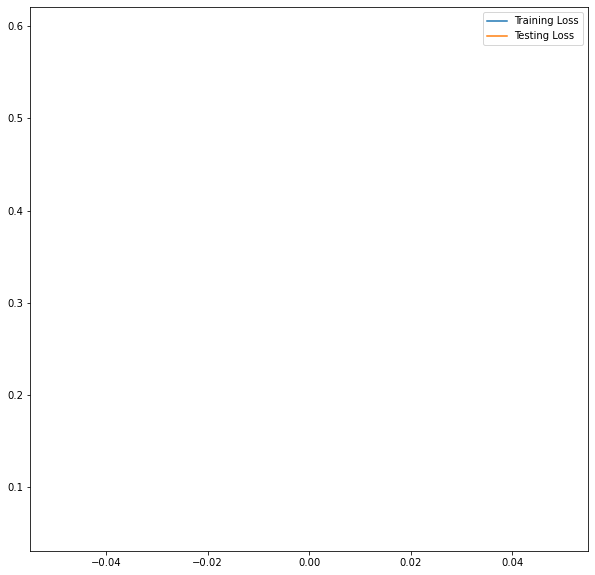

In [16]:
#plotting the loss
f = plt.figure(figsize= (10,10))
plt.plot(train_loss, label = "Training Loss")
plt.plot(test_loss, label = "Testing Loss")
plt.legend()
plt.show()

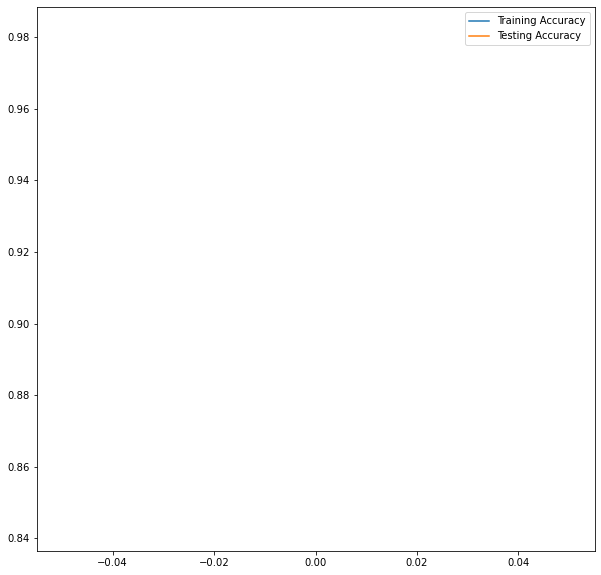

In [17]:
#plotting the accuracy
f = plt.figure(figsize= (10,10))
plt.plot(train_accuracy, label = "Training Accuracy")
plt.plot(test_accuracy, label = "Testing Accuracy")
plt.legend()
plt.show()

prediction: 3
Actual: 5


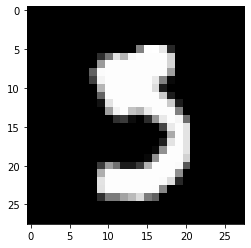

In [18]:
img_index = 5937
img = test_dataset[img_index][0].view((1,1,28,28))
labels = test_dataset[img_index][1]

model.eval()
if CUDA:
    model = model.cuda()
    img = img.cuda()
    
output = model(img)
_, predicted = torch.max(output, dim= 1)

random_img = test_dataset[img_index][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_img.reshape(28,28), cmap = 'gray')
print("prediction: {}".format(predicted.item()))
print("Actual: {}".format(labels))